In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from datetime import datetime
from matplotlib import pyplot
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv1D, Conv2D, Input, Dropout, Activation, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-02-14 10:23:32.


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow.")

import tensorflow as tf
print("\nTensorFlow version: ", tf.__version__)
print("\nIs GPU available?", tf.test.is_gpu_available())
print("\nNum GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nPhysical Devices: ", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
print("\nLocal devices:", device_lib.list_local_devices())

Please install GPU version of TensorFlow.

TensorFlow version:  2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Is GPU available? False

Num GPUs Available:  0

Physical Devices:  []

Local devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8717050206886557652
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2314853409722236053
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
filepath = "../Data Preprocessing/iot23_combined_1000k.csv"
df = pd.read_csv(filepath)

In [5]:
df

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1,1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2,2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
3,3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
4,4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13200770,999994,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
13200771,999995,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
13200772,999996,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
13200773,999997,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0


In [6]:
del df['Unnamed: 0']

In [7]:
df['label'].value_counts()

PartOfAHorizontalPortScan     7459222
Okiru                         2626257
Benign                        1827145
DDoS                          1263025
C&C                             15520
Attack                           6943
C&C-HeartBeat                    2561
C&C-FileDownload                   46
C&C-Torii                          30
FileDownload                       14
C&C-HeartBeat-FileDownload          8
Okiru-Attack                        3
C&C-Mirai                           1
Name: label, dtype: int64

In [8]:
X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']].values

In [9]:
X.shape

(13200775, 24)

In [10]:
Y = pd.get_dummies(df['label']).values

In [11]:
Y.shape

(13200775, 13)

In [12]:
df

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,...,0,0,0,1,0,0,0,0,0,0
4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13200770,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
13200771,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
13200772,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0
13200773,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(X)

MinMaxScaler()

In [15]:
normalized_x = scaler.transform(X)

In [16]:
normalized_x

array([[4.28682655e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07202932e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07202932e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.07202932e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07202932e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07202932e-05, 5.73121586e-10, 8.57558209e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [17]:
normalized_x.shape

(13200775, 24)

In [18]:
scaler.fit(Y)

MinMaxScaler()

In [19]:
normalized_y = scaler.transform(Y)

In [20]:
normalized_y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV

estimator = DecisionTreeClassifier(random_state=10)
selector = RFECV(estimator, step=1, cv=5, n_jobs=-1, verbose=3)
selector = selector.fit(normalized_x, normalized_y)
print('Support:',selector.support_)
print('Ranking:',selector.ranking_)
normalized_x = selector.transform(normalized_x)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Support: [ True  True  True False False  True  True  True  True False  True  True
 False False False False False  True False False  True  True False False]
Ranking: [ 1  1  1  5  7  1  1  1  1 11  1  1  3  2  4  6 10  1  9  8  1  1 12 13]


In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_x, normalized_y, random_state=10, test_size=0.2)

In [62]:
X_train.shape

(10560620, 12)

In [63]:
batch_size = 256
num_epochs = 10
loss = 'categorical_crossentropy'
optimizer = Nadam(learning_rate=0.01)
metrics = ['accuracy']

In [70]:
model = Sequential()

model.add(Dense(2048,activation='relu',input_dim=X_train.shape[-1]))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(Y_train.shape[-1], activation='softmax'))

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [71]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 1024)              13312     
_________________________________________________________________
dense_75 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_52 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)              

In [72]:
start = time.time()
print('program start...')
print()

history = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.25, verbose=1)

print()
end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...

Epoch 1/10
 1722/30940 [>.............................] - ETA: 3:47 - loss: 2.0162 - accuracy: 0.6364

KeyboardInterrupt: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 723
Traceback (most recent call last):
  File "C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\marce\AppData\Local\Temp/ipykernel_8448/2142186217.py", line 3, in <module>
    ax.plot(np.arange(0,num_epochs), history.history['loss'], label='Loss', color='red')
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ma

TypeError: object of type 'NoneType' has no len()

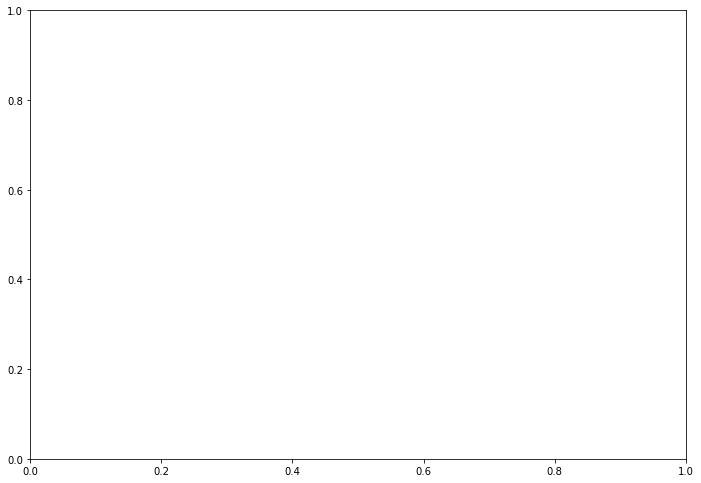

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(11.75,8.25))
ax.plot(np.arange(0,num_epochs), history.history['loss'], label='Loss', color='red')
ax.plot(np.arange(0,num_epochs), history.history['accuracy'], label='Accuracy', color='blue')
ax.grid(True, which='both')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1*np.max([np.max(history.history['loss']),np.max(history.history['accuracy'])]))
#ax.set_title(code.capitalize() + ' code ($M_{ep}=2^{' + str(nb_epoch_exp) + '})$ - ' + optimizer_name)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=batch_size)
print("test loss, test acc:", results)

In [ ]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")